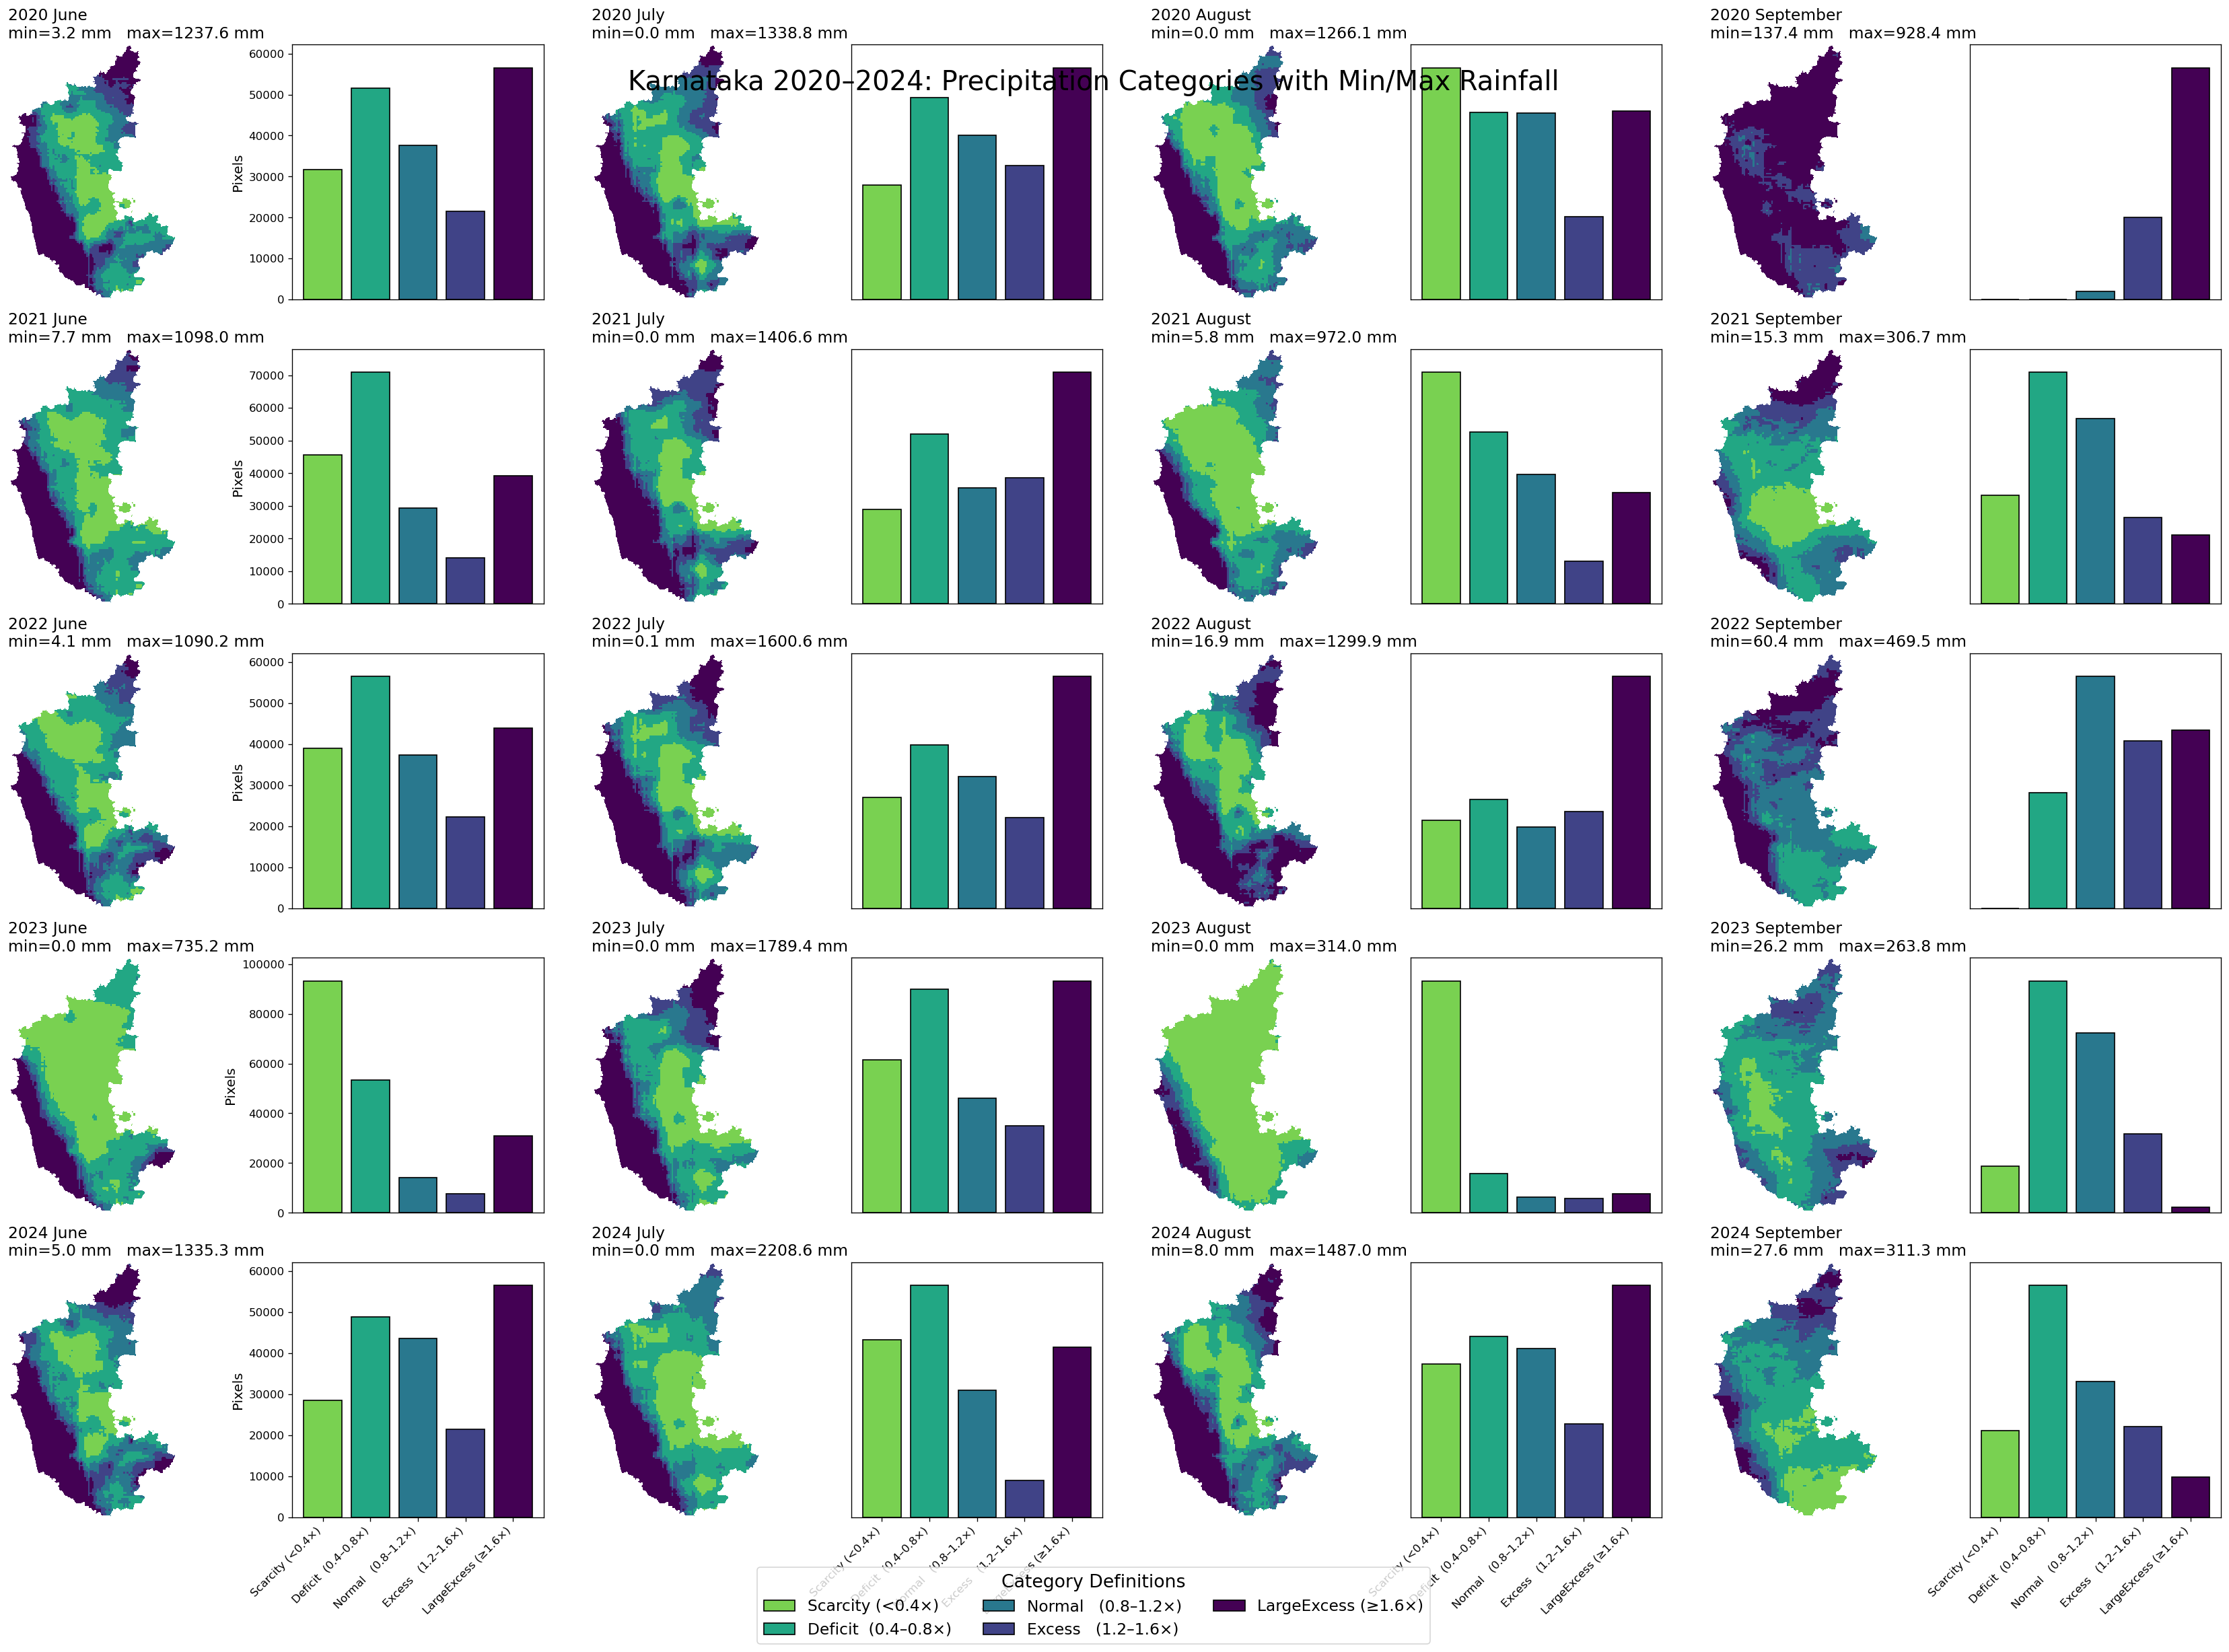

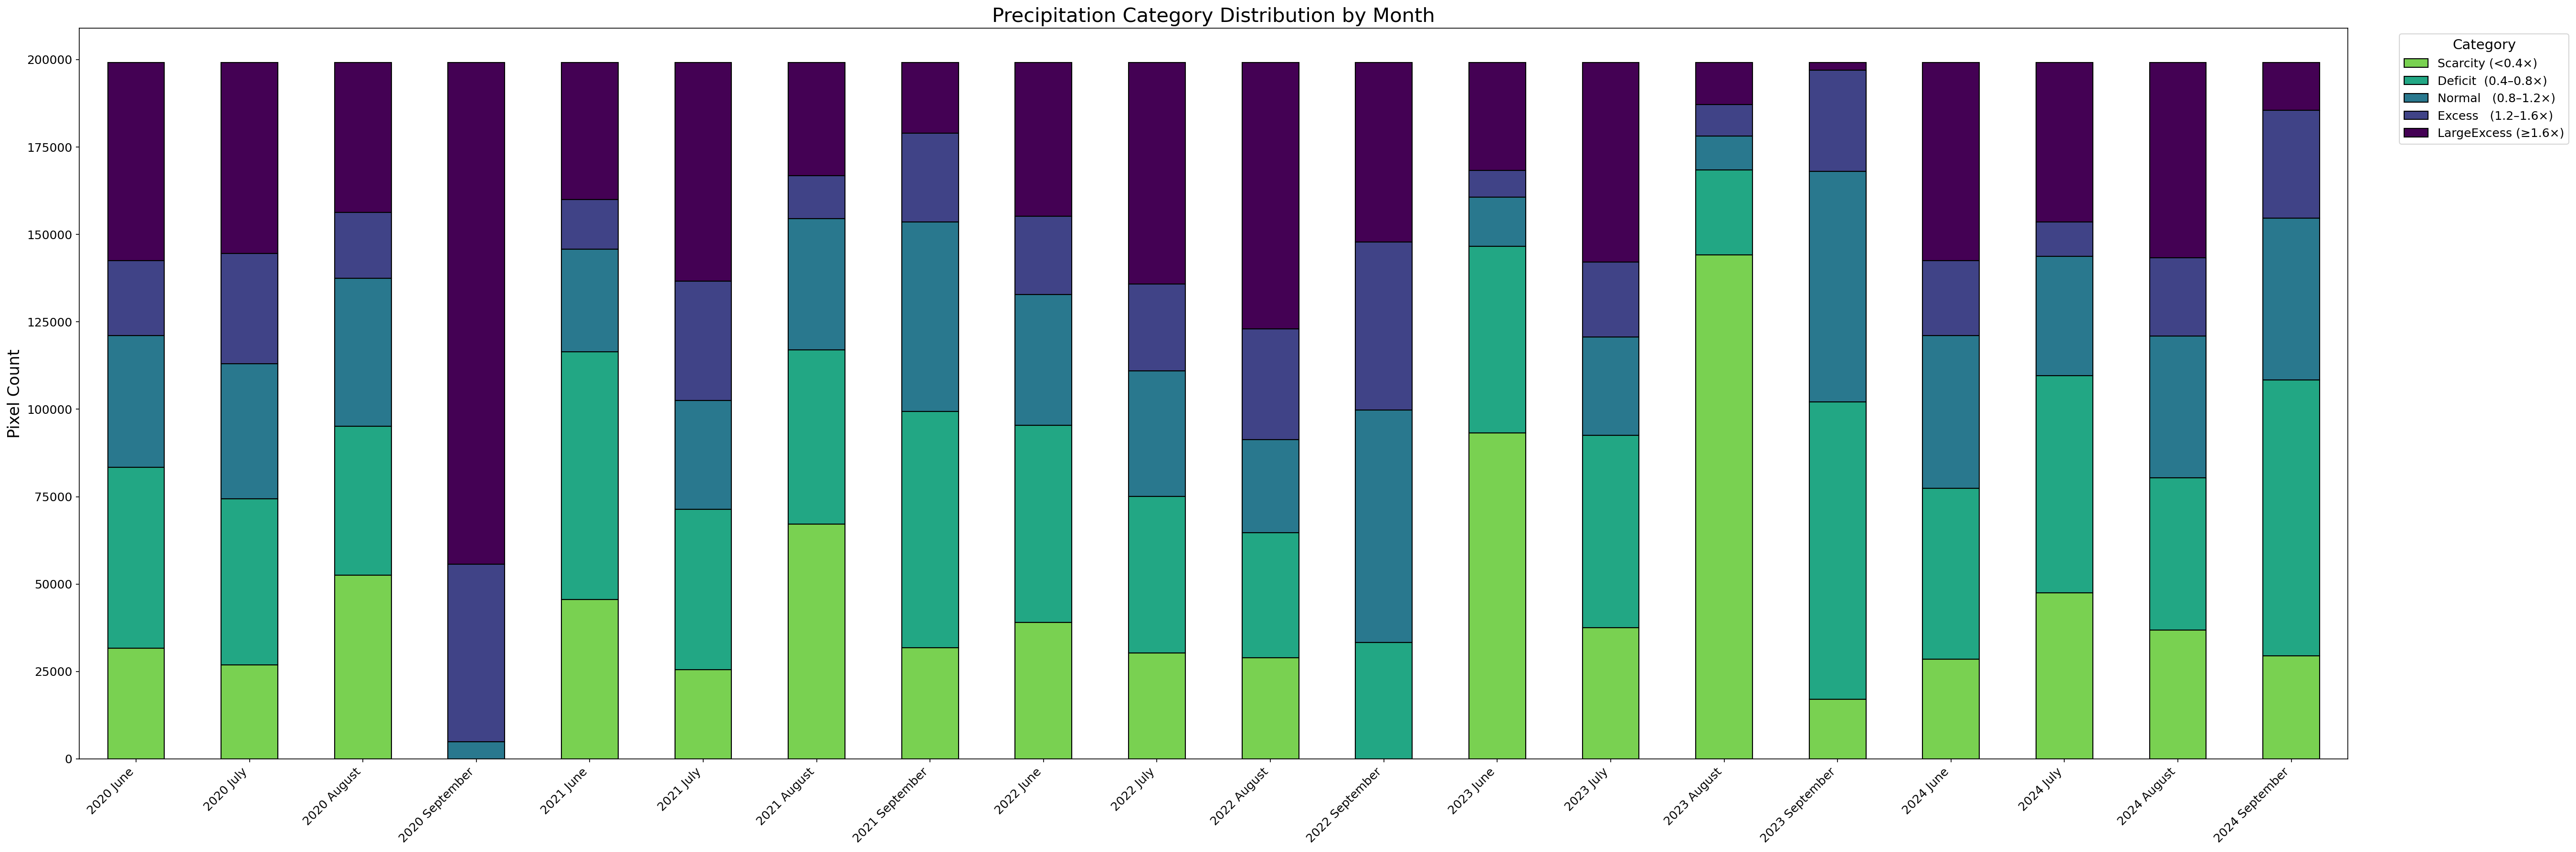

In [26]:
import os
import rasterio
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from rasterio.features import geometry_mask

# -----------------------------------------------------------------------------
# 1) FILE PATHS
# -----------------------------------------------------------------------------
raw_tiff = "Karnataka_Y_Precipitation_CHIRPS.tif"
shpfile  = "SateMask/gadm41_IND_1.shp"
for p in (raw_tiff, shpfile):
    if not os.path.isfile(p):
        raise FileNotFoundError(f"Cannot find {p!r}")

# -----------------------------------------------------------------------------
# 2) LOAD KARNATAKA SHAPE & BUILD MASK
# -----------------------------------------------------------------------------
gdf = gpd.read_file(shpfile)
gdf_kar = gdf[gdf["NAME_1"].str.lower() == "karnataka"].copy()
if gdf_kar.empty:
    raise ValueError("No 'Karnataka' feature in shapefile")

# use one band to get geotransform/crs/shape
with rasterio.open(raw_tiff) as ref:
    transform, crs = ref.transform, ref.crs
    height, width  = ref.height, ref.width
    bounds         = ref.bounds

if gdf_kar.crs != crs:
    gdf_kar = gdf_kar.to_crs(crs)

kar_mask = geometry_mask(
    [gdf_kar.geometry.union_all()],
    transform=transform,
    invert=True,
    out_shape=(height, width)
)

# -----------------------------------------------------------------------------
# 3) READ RAW PRECIPITATION (25 bands)
# -----------------------------------------------------------------------------
with rasterio.open(raw_tiff) as src:
    pr_raw_full = src.read().astype(np.float32)  # shape = (25, H, W)

# drop the annual totals at indices 4,9,14,19,24 → keep only the 20 monthlies
monthly_idxs = []
for y in range(5):
    base = y * 5
    monthly_idxs += [base + m for m in range(4)]
pr_raw = pr_raw_full[monthly_idxs]  # shape = (20, H, W)

# -----------------------------------------------------------------------------
# 4) YOUR NORMALS (June, July, August, September)
# -----------------------------------------------------------------------------
normals = [127.5, 158.55, 149.45, 144.1]

def categorize(data, normal):
    """
    data: 2D array of rainfall
    normal: scalar normal for that month
    returns: 2D array of ints 0..4 (categories), NaN where mask==False
    """
    cat = np.full(data.shape, np.nan, dtype=np.float32)
    valid = ~np.isnan(data)
    r = data[valid] / normal
    out = np.zeros_like(r, dtype=np.int8)
    out[r < 0.4] = 0
    out[(r >= 0.4) & (r < 0.8)] = 1
    out[(r >= 0.8) & (r < 1.2)] = 2
    out[(r >= 1.2) & (r < 1.6)] = 3
    out[r >= 1.6] = 4
    cat[valid] = out
    return cat

# build category stack on the fly
pr_cat = np.full(pr_raw.shape, np.nan, dtype=np.float32)
for i in range(pr_raw.shape[0]):
    m = i % 4
    pr_cat[i] = categorize(pr_raw[i], normals[m])

# -----------------------------------------------------------------------------
# 5) SETUP LABELS, COLORS & LEGEND
# -----------------------------------------------------------------------------
years   = [2020, 2021, 2022, 2023, 2024]
months  = ["June", "July", "August", "September"]
labels  = [f"{years[i//4]} {months[i%4]}" for i in range(20)]

colors    = ["#79d151", "#22a784", "#29788e", "#404387", "#440154"]
cmap      = ListedColormap(colors)
cat_names = [
    "Scarcity (<0.4×)", "Deficit  (0.4–0.8×)",
    "Normal   (0.8–1.2×)", "Excess   (1.2–1.6×)",
    "LargeExcess (≥1.6×)"
]
legend_handles = [
    Patch(facecolor=colors[i], edgecolor="black", label=cat_names[i])
    for i in range(5)
]

# -----------------------------------------------------------------------------
# 6) PLOT: 5×8 GRID (map + histogram per month)
# -----------------------------------------------------------------------------
fig, axes = plt.subplots(
    nrows=5, ncols=8,
    figsize=(28, 20),
    dpi=120,
    constrained_layout=True
)
fig.suptitle(
    "Karnataka 2020–2024: Precipitation Categories with Min/Max Rainfall",
    fontsize=24, y=0.96
)

for yr in range(5):
    for mo in range(4):
        idx     = yr*4 + mo
        ax_map  = axes[yr, mo*2]
        ax_hist = axes[yr, mo*2+1]

        # compute min/max over Karnataka mask
        vals    = pr_raw[idx][kar_mask]
        pr_min  = np.nanmin(vals)
        pr_max  = np.nanmax(vals)

        # plot category map
        arr = pr_cat[idx]
        plot_arr = np.where(kar_mask, arr, np.nan)

        ax_map.imshow(
            plot_arr,
            cmap=cmap, vmin=0, vmax=4,
            extent=[bounds.left, bounds.right, bounds.bottom, bounds.top],
            origin="upper"
        )
        ax_map.set_title(
            f"{labels[idx]}\nmin={pr_min:.1f} mm   max={pr_max:.1f} mm",
            fontsize=14, loc="left"
        )
        ax_map.axis("off")

        # histogram of pixel counts per category
        counts = [(arr[kar_mask] == i).sum() for i in range(5)]
        ax_hist.bar(
            range(5), counts,
            color=colors, edgecolor="black"
        )
        if yr == 4:
            ax_hist.set_xticks(range(5))
            ax_hist.set_xticklabels(cat_names, rotation=45, ha="right", fontsize=10)
        else:
            ax_hist.set_xticks([])
        if mo == 0:
            ax_hist.set_ylabel("Pixels", fontsize=12)
        else:
            ax_hist.set_yticks([])
        ax_hist.set_ylim(0, max(counts)*1.1)

# shared legend
fig.legend(
    handles=legend_handles,
    loc="lower center",
    ncol=3,
    frameon=True,
    title="Category Definitions",
    fontsize=14,
    title_fontsize=16,
    bbox_to_anchor=(0.5, -0.02)
)
plt.show()

# -----------------------------------------------------------------------------
# 7) STACKED‐BAR SUMMARY ACROSS ALL 20 MONTHS
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------
# 7) ENLARGED STACKED‐BAR COMPARISON ACROSS ALL 20 MONTHS (BIGGER!)
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------
# 7) ENLARGED STACKED‐BAR COMPARISON ACROSS ALL 20 MONTHS (FIXED Y‐TICK WARNING)
# -----------------------------------------------------------------------------
data = {
    cat_names[i]: [(pr_cat[j][kar_mask] == i).sum() for j in range(20)]
    for i in range(5)
}
df = pd.DataFrame(data, index=labels)

# Create a really big, high-res figure
fig, ax = plt.subplots(figsize=(36, 12), dpi=150)

# Plot the stacked bar
df.plot(
    kind="bar",
    stacked=True,
    colormap=ListedColormap(colors),
    edgecolor="black",
    ax=ax
)

# Tweak x‐labels
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=45, ha="right", fontsize=12)

# Use tick_params to set the y‐axis label size (no set_yticklabels)
ax.tick_params(axis="y", labelsize=12)

ax.set_ylabel("Pixel Count", fontsize=16)
ax.set_title("Precipitation Category Distribution by Month", fontsize=20)

ax.legend(
    title="Category",
    fontsize=12,
    title_fontsize=14,
    bbox_to_anchor=(1.02, 1),
    loc="upper left"
)

plt.tight_layout()
plt.show()




In [ ]:
##Karnataka_X_LST

Total pixels inside Karnataka: 199119
2020 June → LST missing: 17659/199119 (8.87%)
2020 June → Raw Precip missing: 3/199119 (0.00%)
2020 July → LST missing: 147114/199119 (73.88%)
2020 July → Raw Precip missing: 3/199119 (0.00%)
2020 August → LST missing: 78548/199119 (39.45%)
2020 August → Raw Precip missing: 3/199119 (0.00%)
2020 September → LST missing: 22135/199119 (11.12%)
2020 September → Raw Precip missing: 3/199119 (0.00%)
2021 June → LST missing: 5958/199119 (2.99%)
2021 June → Raw Precip missing: 3/199119 (0.00%)
2021 July → LST missing: 107581/199119 (54.03%)
2021 July → Raw Precip missing: 3/199119 (0.00%)
2021 August → LST missing: 37944/199119 (19.06%)
2021 August → Raw Precip missing: 3/199119 (0.00%)
2021 September → LST missing: 15299/199119 (7.68%)
2021 September → Raw Precip missing: 3/199119 (0.00%)
2022 June → LST missing: 2532/199119 (1.27%)
2022 June → Raw Precip missing: 3/199119 (0.00%)
2022 July → LST missing: 66181/199119 (33.24%)
2022 July → Raw Precip miss

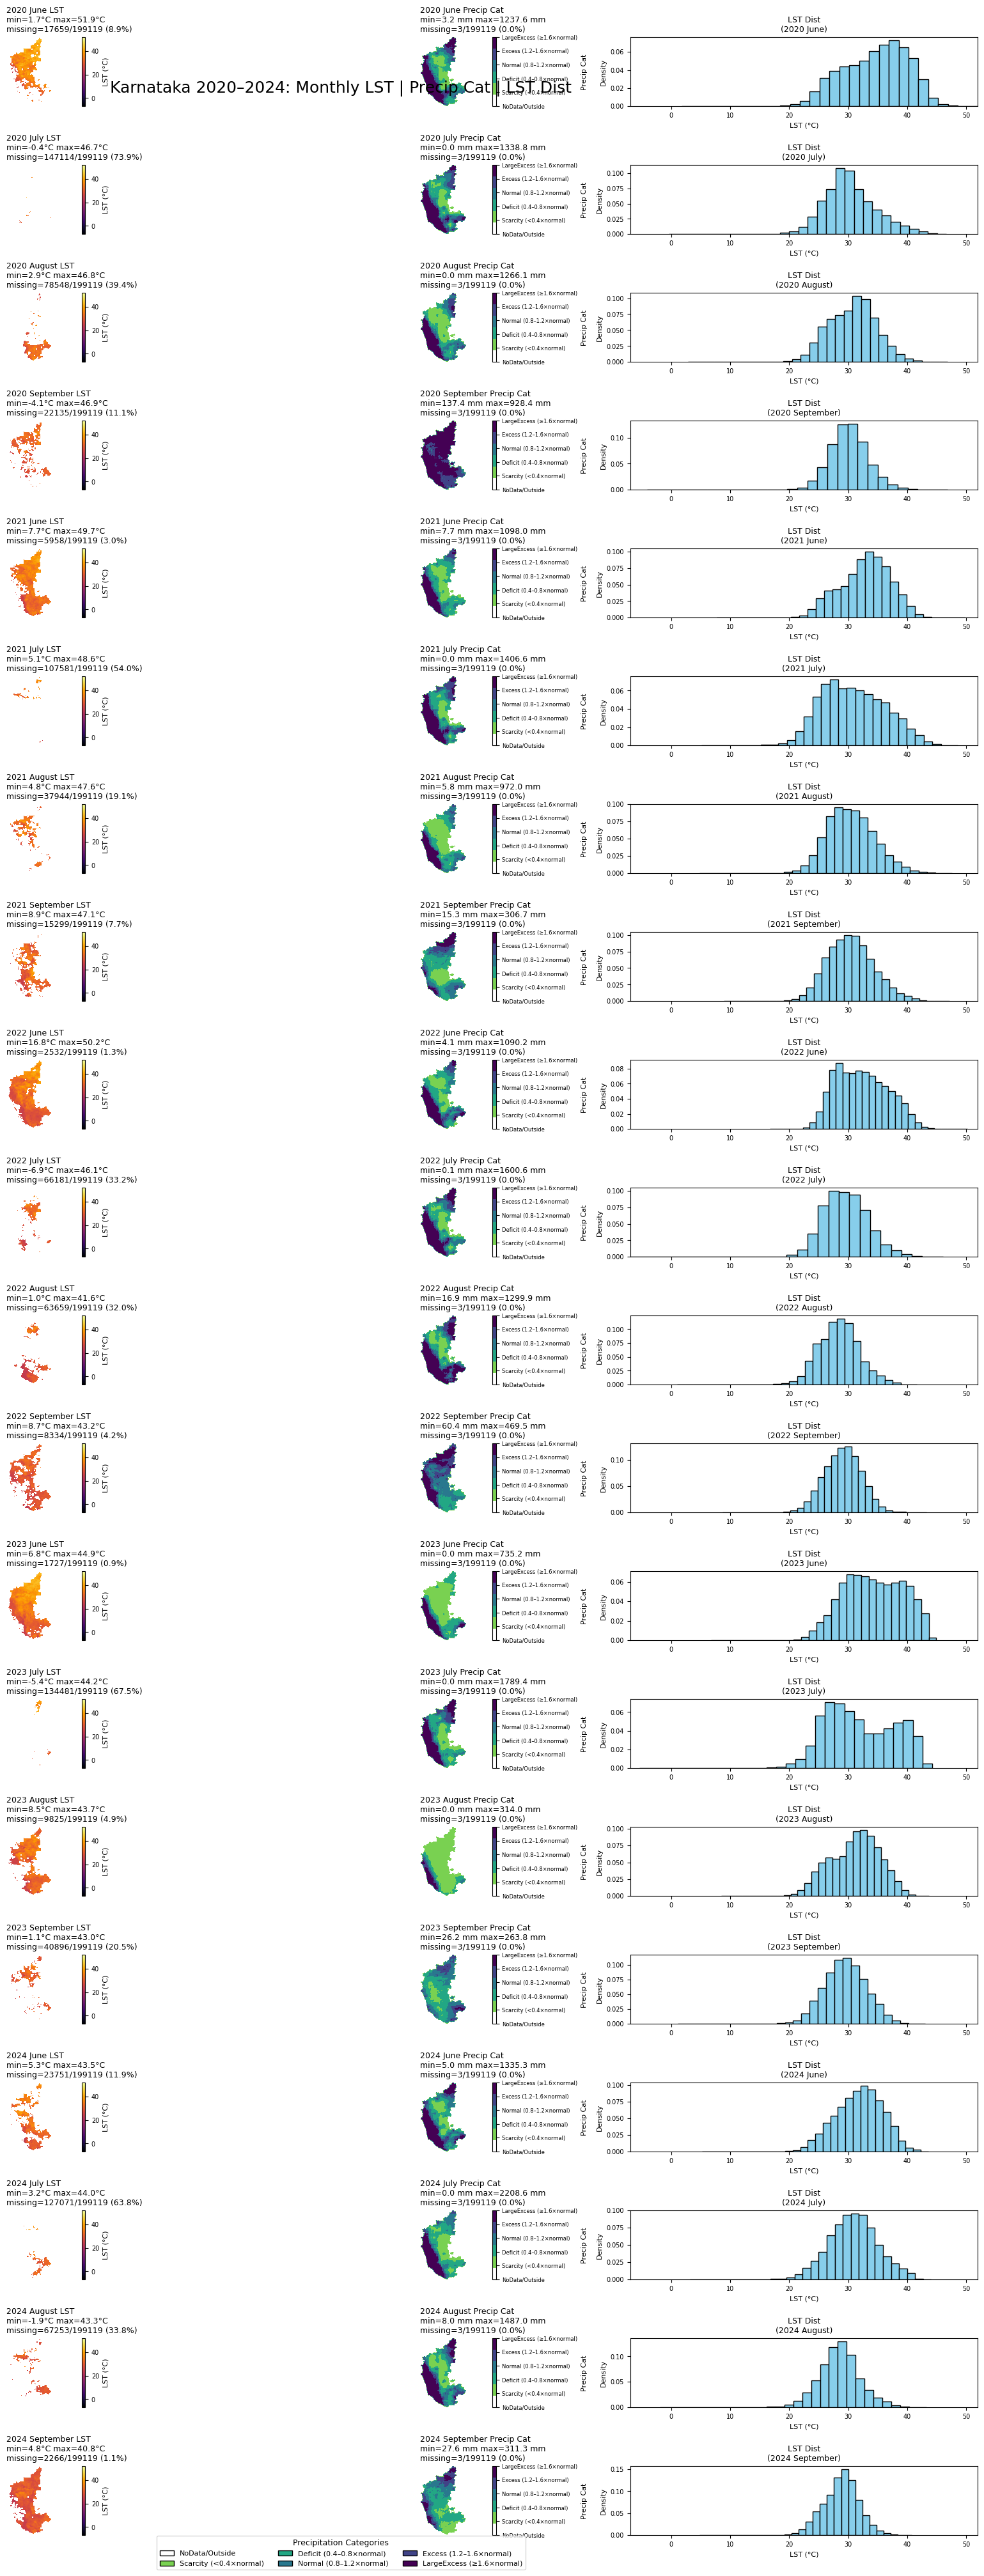

In [1]:
import os
import rasterio
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from rasterio.features import geometry_mask

# -----------------------------------------------------------------------------
# 1) FILE PATHS (for Karnataka)
# -----------------------------------------------------------------------------
lst_tiff_path        = "Karnataka_X_LST.tif"                      # 20 bands (2020–2024 × 4: Jun–Sep)
precip_raw_tiff_path = "Karnataka_Y_Precipitation_CHIRPS.tif"     # 25 bands (2020–2024 × 5)
precip_cat_tiff_path = "Karnataka_Y_Precipitation_GT_geotif.tif"  # 25 bands (2020–2024 × 5)
india_shapefile      = "SateMask/gadm41_IND_1.shp"              

for p in (lst_tiff_path, precip_raw_tiff_path, precip_cat_tiff_path, india_shapefile):
    if not os.path.isfile(p):
        raise FileNotFoundError(f"Cannot find {p!r} in {os.getcwd()}")

# -----------------------------------------------------------------------------
# 2) LOAD INDIA STATES & BUILD KARNATAKA MASK
# -----------------------------------------------------------------------------
gdf = gpd.read_file(india_shapefile)
gdf_kar = gdf[gdf["NAME_1"].str.lower() == "karnataka"]
if gdf_kar.empty:
    raise ValueError("No 'Karnataka' feature found in shapefile.")

with rasterio.open(lst_tiff_path) as src:
    transform = src.transform
    crs       = src.crs
    height    = src.height
    width     = src.width

if gdf_kar.crs != crs:
    gdf_kar = gdf_kar.to_crs(crs)

kar_geom = [gdf_kar.geometry.union_all()]
kar_mask = geometry_mask(
    kar_geom,
    transform=transform,
    invert=True,
    out_shape=(height, width)
)

total_inside = np.count_nonzero(kar_mask)
print(f"Total pixels inside Karnataka: {total_inside}")

# -----------------------------------------------------------------------------
# 3) READ & MASK LST
# -----------------------------------------------------------------------------
with rasterio.open(lst_tiff_path) as src:
    lst_bands = src.read().astype(np.float32)  # (20, H, W)

if lst_bands.shape[0] != 20:
    raise ValueError(f"Expected 20 bands in {lst_tiff_path}, found {lst_bands.shape[0]}")

for i in range(lst_bands.shape[0]):
    b = lst_bands[i]
    b[~kar_mask] = np.nan
    lst_bands[i] = b

# -----------------------------------------------------------------------------
# 4) READ & MASK RAW PRECIPITATION
# -----------------------------------------------------------------------------
with rasterio.open(precip_raw_tiff_path) as src:
    pr_raw_full = src.read().astype(np.float32)  # (25, H, W)

if pr_raw_full.shape[0] != 25:
    raise ValueError(f"Expected 25 bands in raw precip, found {pr_raw_full.shape[0]}")

for i in range(pr_raw_full.shape[0]):
    arr = pr_raw_full[i]
    arr[~kar_mask] = np.nan
    pr_raw_full[i] = arr

# -----------------------------------------------------------------------------
# 5) READ & MASK PRECIPITATION CATEGORY
# -----------------------------------------------------------------------------
with rasterio.open(precip_cat_tiff_path) as src:
    pr_cat_full = src.read().astype(np.int8)  # (25, H, W)

if pr_cat_full.shape[0] != 25:
    raise ValueError(f"Expected 25 bands in precip cat, found {pr_cat_full.shape[0]}")

for i in range(pr_cat_full.shape[0]):
    arr = pr_cat_full[i]
    arr[~kar_mask] = -1
    pr_cat_full[i] = arr

# -----------------------------------------------------------------------------
# 6) EXTRACT 20 MONTHLY BANDS (drop each year's “Total”)
# -----------------------------------------------------------------------------
monthly_idxs = []
for y in range(5):
    base = y * 5
    monthly_idxs += [base + m for m in range(4)]

precip_raw_bands = pr_raw_full[monthly_idxs]  # (20, H, W)
precip_cat_bands = pr_cat_full[monthly_idxs]  # (20, H, W)

# -----------------------------------------------------------------------------
# 7) SETUP YEARS, MONTHS & COLORMAPS
# -----------------------------------------------------------------------------
years       = [2020, 2021, 2022, 2023, 2024]
months      = ["June", "July", "August", "September"]
n_years, n_months = len(years), len(months)
n_total     = n_years * n_months  # 20

all_lst = lst_bands.flatten()
all_lst = all_lst[~np.isnan(all_lst)]
lst_vmin = float(np.nanmin(all_lst)) if all_lst.size else 0.0
lst_vmax = float(np.nanmax(all_lst)) if all_lst.size else 50.0
lst_cmap = plt.get_cmap("inferno")

cluster_colors = ["#ffffff","#79d151","#22a784","#29788e","#404387","#440154"]
cluster_cmap    = ListedColormap(cluster_colors)
cluster_labels  = {
    0:"NoData/Outside",1:"Scarcity (<0.4×normal)",2:"Deficit (0.4–0.8×normal)",
    3:"Normal (0.8–1.2×normal)",4:"Excess (1.2–1.6×normal)",5:"LargeExcess (≥1.6×normal)"
}
cluster_handles = [
    Patch(facecolor=cluster_colors[i], edgecolor="black", label=cluster_labels[i])
    for i in range(6)
]

# -----------------------------------------------------------------------------
# 8) BUILD FIGURE
# -----------------------------------------------------------------------------
fig, axes = plt.subplots(n_total, 3, figsize=(20, n_total*2.0), constrained_layout=True)
fig.suptitle("Karnataka 2020–2024: Monthly LST | Precip Cat | LST Dist", fontsize=18, y=0.97)
if n_total == 1:
    axes = axes[np.newaxis, :]

# -----------------------------------------------------------------------------
# 9) LOOP & PLOT WITH MISSING STATS
# -----------------------------------------------------------------------------
for i in range(n_total):
    yidx, midx = divmod(i, n_months)
    year, mon = years[yidx], months[midx]

    # LST
    layer = lst_bands[i]
    valid = layer[~np.isnan(layer)]
    mn, mx = (float(np.nanmin(valid)), float(np.nanmax(valid))) if valid.size else (np.nan, np.nan)
    miss_lst = np.count_nonzero(np.isnan(layer[kar_mask]))
    pct_lst  = miss_lst / total_inside * 100
    print(f"{year} {mon} → LST missing: {miss_lst}/{total_inside} ({pct_lst:.2f}%)")

    # Precip
    pr_layer = precip_raw_bands[i]
    vpr = pr_layer[~np.isnan(pr_layer)]
    pr_min, pr_max = (float(np.nanmin(vpr)), float(np.nanmax(vpr))) if vpr.size else (np.nan, np.nan)
    miss_pr = np.count_nonzero(np.isnan(pr_layer[kar_mask]))
    pct_pr  = miss_pr / total_inside * 100
    print(f"{year} {mon} → Raw Precip missing: {miss_pr}/{total_inside} ({pct_pr:.2f}%)")

    # Category
    rc = precip_cat_bands[i]
    cp = np.zeros_like(rc, dtype=np.int8)
    ok = (rc != -1)
    cp[ok] = rc[ok] + 1

    # Column 0
    ax0 = axes[i,0]
    im0 = ax0.imshow(layer, cmap=lst_cmap, vmin=lst_vmin, vmax=lst_vmax)
    t0 = (f"{year} {mon} LST\nmin={mn:.1f}°C max={mx:.1f}°C\n"
          f"missing={miss_lst}/{total_inside} ({pct_lst:.1f}%)")
    ax0.set_title(t0, loc="left", fontsize=9)
    ax0.axis("off")
    c0 = fig.colorbar(im0, ax=ax0, fraction=0.04, pad=0.02)
    c0.set_label("LST (°C)", fontsize=8)
    c0.ax.tick_params(labelsize=7)

    # Column 1
    ax1 = axes[i,1]
    im1 = ax1.imshow(cp, cmap=cluster_cmap, vmin=0, vmax=5)
    t1 = (f"{year} {mon} Precip Cat\nmin={pr_min:.1f} mm max={pr_max:.1f} mm\n"
          f"missing={miss_pr}/{total_inside} ({pct_pr:.1f}%)")
    ax1.set_title(t1, loc="left", fontsize=9)
    ax1.axis("off")
    c1 = fig.colorbar(im1, ax=ax1, fraction=0.04, pad=0.02)
    c1.set_ticks([0,1,2,3,4,5])
    c1.set_ticklabels([cluster_labels[j] for j in range(6)], fontsize=6)
    c1.ax.tick_params(labelsize=6)
    c1.set_label("Precip Cat", fontsize=8)

    # Column 2
    ax2 = axes[i,2]
    if valid.size:
        ax2.hist(valid.flatten(), bins=30, density=True, edgecolor="black", color="skyblue")
        ax2.set_xlim(lst_vmin, lst_vmax)
    else:
        ax2.text(0.5,0.5,"No Data", ha="center", va="center", fontsize=8, color="gray")
    ax2.set_title(f"LST Dist\n({year} {mon})", fontsize=9)
    ax2.set_xlabel("LST (°C)", fontsize=8)
    ax2.set_ylabel("Density", fontsize=8)
    ax2.tick_params(labelsize=7)

# -----------------------------------------------------------------------------
# 10) LEGEND
# -----------------------------------------------------------------------------
fig.legend(
    handles=cluster_handles,
    labels=[cluster_labels[j] for j in range(6)],
    loc="lower center",
    ncol=3,
    frameon=True,
    title="Precipitation Categories",
    fontsize=8,
    title_fontsize=9,
    bbox_to_anchor=(0.5, -0.005)
)

plt.show()


In [ ]:
##Karnataka_X_NDVI

Total pixels inside Karnataka (NDVI): 796415
Total pixels inside Karnataka (Precip): 199119

2020 June → NDVI missing: 221/796415 (0.03%)
            Precip missing: 3/199119 (0.00%)

2020 July → NDVI missing: 234/796415 (0.03%)
            Precip missing: 3/199119 (0.00%)

2020 August → NDVI missing: 248/796415 (0.03%)
            Precip missing: 3/199119 (0.00%)

2020 September → NDVI missing: 241/796415 (0.03%)
            Precip missing: 3/199119 (0.00%)

2021 June → NDVI missing: 246/796415 (0.03%)
            Precip missing: 3/199119 (0.00%)

2021 July → NDVI missing: 240/796415 (0.03%)
            Precip missing: 3/199119 (0.00%)

2021 August → NDVI missing: 235/796415 (0.03%)
            Precip missing: 3/199119 (0.00%)

2021 September → NDVI missing: 232/796415 (0.03%)
            Precip missing: 3/199119 (0.00%)

2022 June → NDVI missing: 207/796415 (0.03%)
            Precip missing: 3/199119 (0.00%)

2022 July → NDVI missing: 239/796415 (0.03%)
            Precip missing: 3

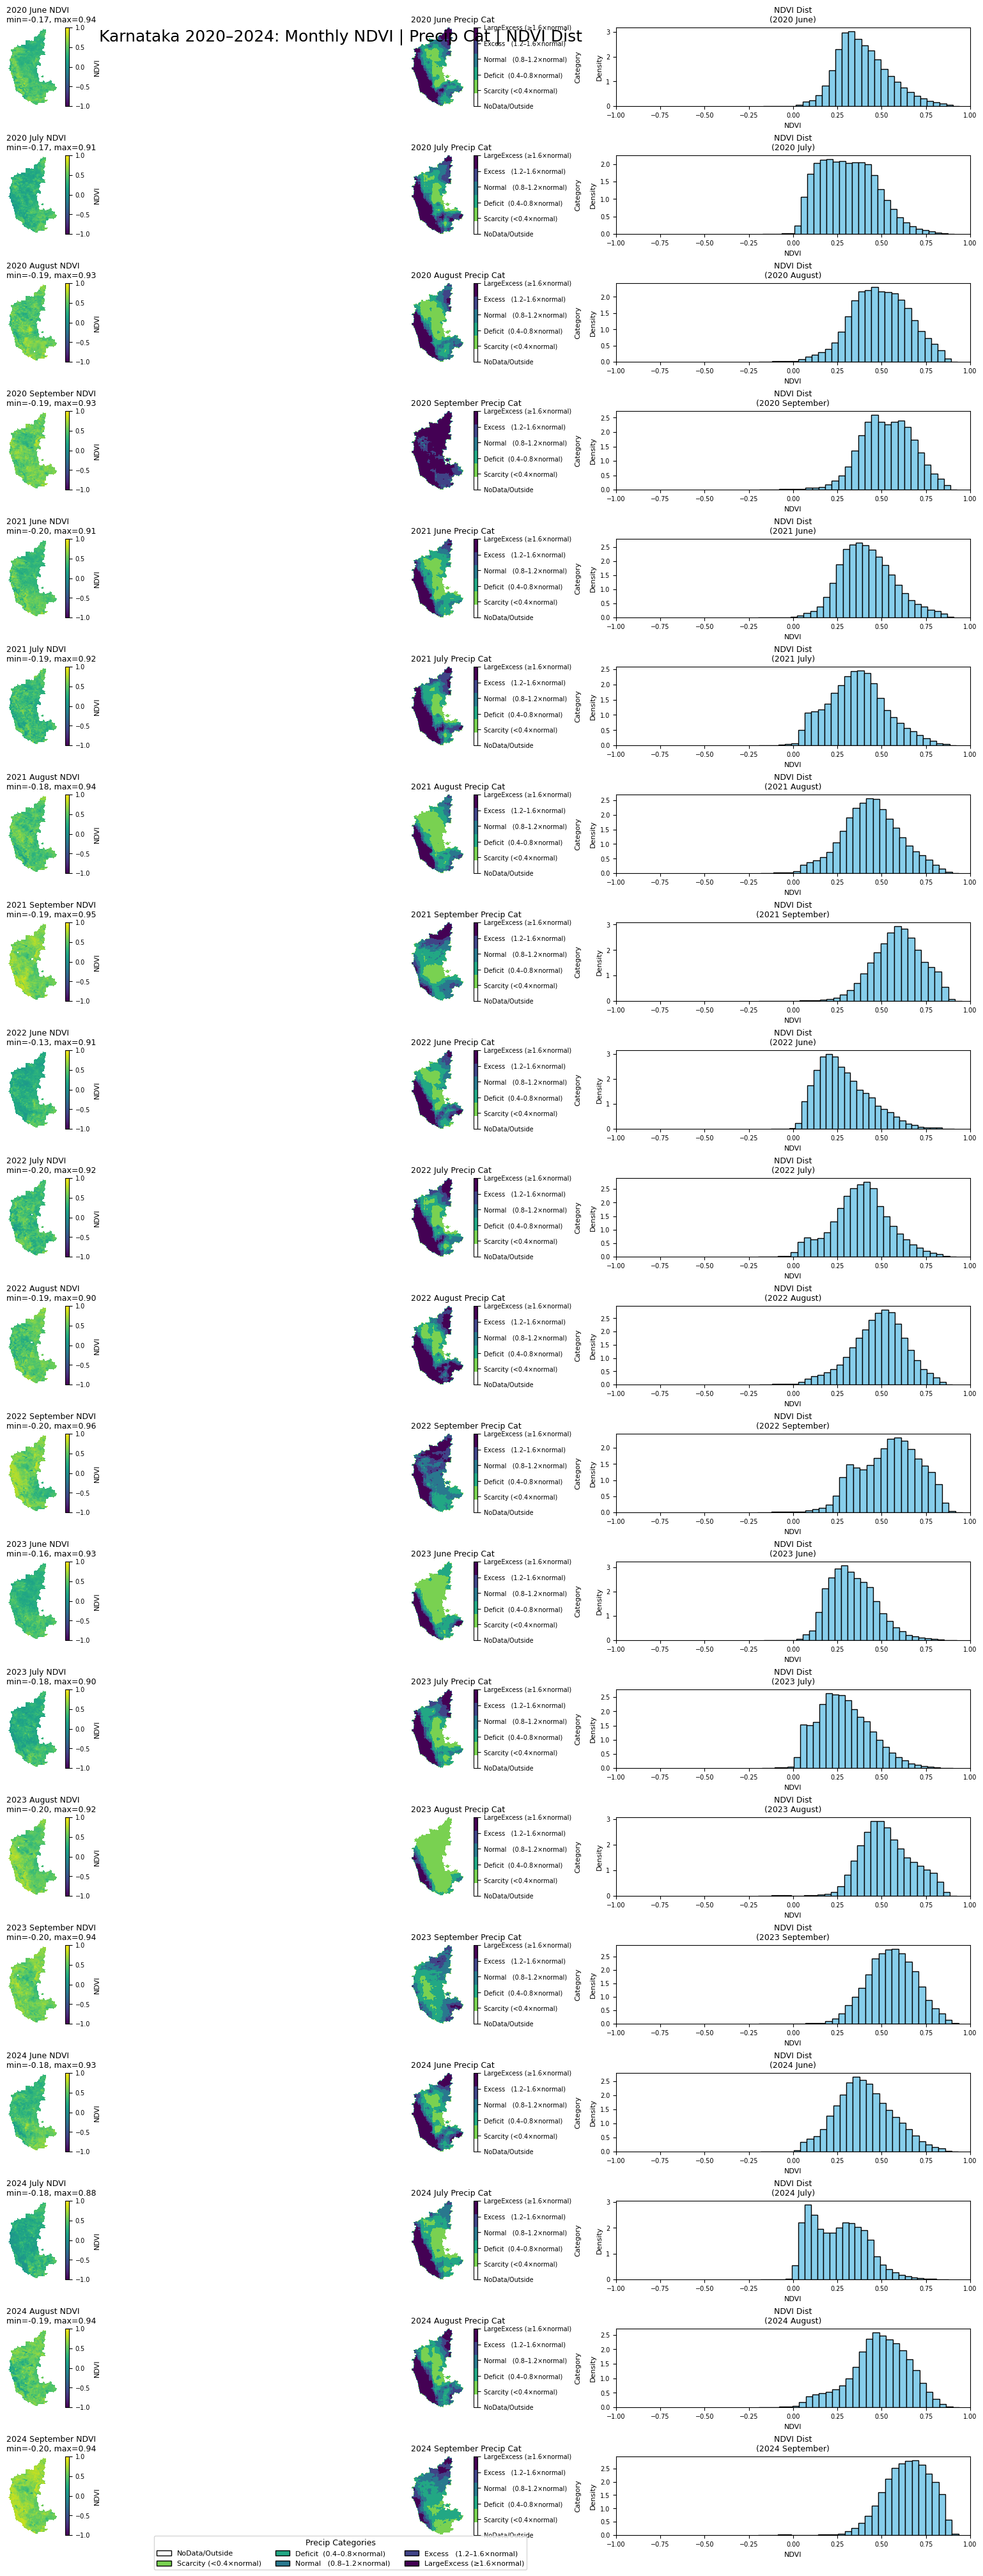

In [10]:
import os
import rasterio
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from rasterio.features import geometry_mask

# -----------------------------------------------------------------------------
# 1) FILE PATHS (for Karnataka)
# -----------------------------------------------------------------------------
ndvi_tiff        = "Karnataka_X_NDVI.tif"
precip_raw_tiff  = "Karnataka_Y_Precipitation_CHIRPS.tif"
precip_cat_tiff  = "Karnataka_Y_Precipitation_GT_geotif.tif"
india_shapefile  = "SateMask/gadm41_IND_1.shp"

for p in (ndvi_tiff, precip_raw_tiff, precip_cat_tiff, india_shapefile):
    if not os.path.isfile(p):
        raise FileNotFoundError(f"Cannot find {p!r} in {os.getcwd()}")

# -----------------------------------------------------------------------------
# 2) LOAD & MASK NDVI
# -----------------------------------------------------------------------------
with rasterio.open(ndvi_tiff) as src:
    ndvi      = src.read().astype(np.float32)  # (20, H_nd, W_nd)
    tr_nd, crs_nd = src.transform, src.crs
    H_nd, W_nd   = src.height, src.width
    bounds_nd    = src.bounds

if ndvi.shape[0] != 20:
    raise ValueError("Expected 20 NDVI bands")

gdf = gpd.read_file(india_shapefile)
gdf_kar = gdf[gdf["NAME_1"].str.lower() == "karnataka"]
if gdf_kar.empty:
    raise ValueError("No 'Karnataka' in shapefile")
gdf_kar = gdf_kar.to_crs(crs_nd)
mask_nd = geometry_mask([gdf_kar.geometry.union_all()],
                        transform=tr_nd, invert=True,
                        out_shape=(H_nd, W_nd))
total_nd = mask_nd.sum()
for i in range(20):
    b = ndvi[i]
    b[~mask_nd] = np.nan
    ndvi[i] = b

# -----------------------------------------------------------------------------
# 3) LOAD & MASK RAW PRECIPITATION
# -----------------------------------------------------------------------------
with rasterio.open(precip_raw_tiff) as src:
    pr_raw, tr_pr, crs_pr = src.read().astype(np.float32), src.transform, src.crs
    H_pr, W_pr = src.height, src.width

if pr_raw.shape[0] != 25:
    raise ValueError("Expected 25 precip bands")

gdf_kar_pr = gdf_kar.to_crs(crs_pr)
mask_pr = geometry_mask([gdf_kar_pr.geometry.union_all()],
                        transform=tr_pr, invert=True,
                        out_shape=(H_pr, W_pr))
total_pr = mask_pr.sum()
for i in range(25):
    a = pr_raw[i]
    a[~mask_pr] = np.nan
    pr_raw[i] = a

# -----------------------------------------------------------------------------
# 4) LOAD & MASK PRECIPITATION CATEGORY
# -----------------------------------------------------------------------------
with rasterio.open(precip_cat_tiff) as src:
    pr_cat = src.read().astype(np.int8)

if pr_cat.shape[0] != 25:
    raise ValueError("Expected 25 precip-cat bands")
for i in range(25):
    c = pr_cat[i]
    c[~mask_pr] = -1
    pr_cat[i] = c

# -----------------------------------------------------------------------------
# 5) DROP “TOTAL” EVERY 5th BAND → 20 MONTHS
# -----------------------------------------------------------------------------
idx = [y*5 + m for y in range(5) for m in range(4)]
ndvi_mon   = ndvi
pr_raw_mon = pr_raw[idx]
pr_cat_mon = pr_cat[idx]

# -----------------------------------------------------------------------------
# 6) SETUP YEARS, MONTHS, CMAPS
# -----------------------------------------------------------------------------
years = [2020,2021,2022,2023,2024]
mons  = ["June","July","August","September"]
n_tot = 20

cmap_nd = plt.get_cmap("viridis")
vmin_nd, vmax_nd = -1.0, 1.0

cat_colors = ["#ffffff","#79d151","#22a784","#29788e","#404387","#440154"]
cmap_cat   = ListedColormap(cat_colors)
cat_labels = {
    0:"NoData/Outside",1:"Scarcity (<0.4×normal)",
    2:"Deficit  (0.4–0.8×normal)",3:"Normal   (0.8–1.2×normal)",
    4:"Excess   (1.2–1.6×normal)",5:"LargeExcess (≥1.6×normal)"
}
cat_handles = [Patch(facecolor=cat_colors[i], edgecolor="black", label=cat_labels[i])
               for i in range(6)]

# -----------------------------------------------------------------------------
# 7) PRINT OUT MISSING-DATA STATS
# -----------------------------------------------------------------------------
print(f"Total pixels inside Karnataka (NDVI): {total_nd}")
print(f"Total pixels inside Karnataka (Precip): {total_pr}\n")
for i in range(n_tot):
    yidx, midx = divmod(i, 4)
    yr, mo = years[yidx], mons[midx]

    # NDVI missing
    layer_nd = ndvi_mon[i]
    miss_nd  = np.isnan(layer_nd[mask_nd]).sum()
    pct_nd   = miss_nd/total_nd*100

    # Precip missing
    layer_pr = pr_raw_mon[i]
    miss_pr  = np.isnan(layer_pr[mask_pr]).sum()
    pct_pr   = miss_pr/total_pr*100

    print(f"{yr} {mo} → NDVI missing: {miss_nd}/{total_nd} ({pct_nd:.2f}%)\n"
          f"            Precip missing: {miss_pr}/{total_pr} ({pct_pr:.2f}%)\n")

# -----------------------------------------------------------------------------
# 8) BUILD THE 20×3 PANEL
# -----------------------------------------------------------------------------
fig, axes = plt.subplots(n_tot, 3, figsize=(20, n_tot*2), constrained_layout=True)
fig.suptitle("Karnataka 2020–2024: Monthly NDVI | Precip Cat | NDVI Dist", fontsize=18, y=0.99)
if n_tot==1:
    axes = axes[np.newaxis,:]

for i in range(n_tot):
    yidx, midx = divmod(i,4)
    yr, mo = years[yidx], mons[midx]

    # NDVI
    arr_nd = ndvi_mon[i]
    valid  = arr_nd[~np.isnan(arr_nd)]
    mn, mx = (valid.min(), valid.max()) if valid.size else (np.nan,np.nan)
    ax0 = axes[i,0]
    im0 = ax0.imshow(arr_nd, cmap=cmap_nd, vmin=vmin_nd, vmax=vmax_nd,
                     extent=[bounds_nd.left,bounds_nd.right,bounds_nd.bottom,bounds_nd.top],
                     origin="upper")
    ax0.set_title(f"{yr} {mo} NDVI\nmin={mn:.2f}, max={mx:.2f}", loc="left", fontsize=9)
    ax0.axis("off")
    c0 = fig.colorbar(im0, ax=ax0, fraction=0.04, pad=0.02)
    c0.set_label("NDVI", fontsize=8); c0.ax.tick_params(labelsize=7)

    # Precip Cat
    raw_cat = pr_cat_mon[i]
    disp    = np.zeros_like(raw_cat)
    maskv   = (raw_cat!=-1)
    disp[maskv] = raw_cat[maskv]+1
    ax1 = axes[i,1]
    im1 = ax1.imshow(disp, cmap=cmap_cat, vmin=0, vmax=5)
    ax1.set_title(f"{yr} {mo} Precip Cat", loc="left", fontsize=9)
    ax1.axis("off")
    c1 = fig.colorbar(im1, ax=ax1, fraction=0.04, pad=0.02)
    c1.set_ticks([0,1,2,3,4,5])
    c1.set_ticklabels([cat_labels[j] for j in range(6)], fontsize=6)
    c1.ax.tick_params(labelsize=7); c1.set_label("Category", fontsize=8)

    # NDVI dist
    ax2 = axes[i,2]
    if valid.size:
        ax2.hist(valid.flatten(), bins=30, density=True, edgecolor="black", color="skyblue")
        ax2.set_xlim(vmin_nd, vmax_nd)
    else:
        ax2.text(0.5,0.5,"No Data", ha="center", va="center", color="gray", fontsize=8)
    ax2.set_title(f"NDVI Dist\n({yr} {mo})", fontsize=9)
    ax2.set_xlabel("NDVI", fontsize=8); ax2.set_ylabel("Density", fontsize=8)
    ax2.tick_params(labelsize=7)

# bottom legend
fig.legend(handles=cat_handles, loc="lower center", ncol=3,
           frameon=True, title="Precip Categories",
           fontsize=8, title_fontsize=9, bbox_to_anchor=(0.5,-0.005))

plt.show()


In [ ]:
##Karnataka_X_Relativy_Humadity

Total pixels inside Karnataka boundary: 199119

2020 June → RH missing: 752/199119 (0.38%)  |  Precip missing: 3/199119 (0.00%)
2020 July → RH missing: 752/199119 (0.38%)  |  Precip missing: 3/199119 (0.00%)
2020 August → RH missing: 752/199119 (0.38%)  |  Precip missing: 3/199119 (0.00%)
2020 September → RH missing: 752/199119 (0.38%)  |  Precip missing: 3/199119 (0.00%)
2021 June → RH missing: 752/199119 (0.38%)  |  Precip missing: 3/199119 (0.00%)
2021 July → RH missing: 752/199119 (0.38%)  |  Precip missing: 3/199119 (0.00%)
2021 August → RH missing: 752/199119 (0.38%)  |  Precip missing: 3/199119 (0.00%)
2021 September → RH missing: 752/199119 (0.38%)  |  Precip missing: 3/199119 (0.00%)
2022 June → RH missing: 752/199119 (0.38%)  |  Precip missing: 3/199119 (0.00%)
2022 July → RH missing: 752/199119 (0.38%)  |  Precip missing: 3/199119 (0.00%)
2022 August → RH missing: 752/199119 (0.38%)  |  Precip missing: 3/199119 (0.00%)
2022 September → RH missing: 752/199119 (0.38%)  |  Prec

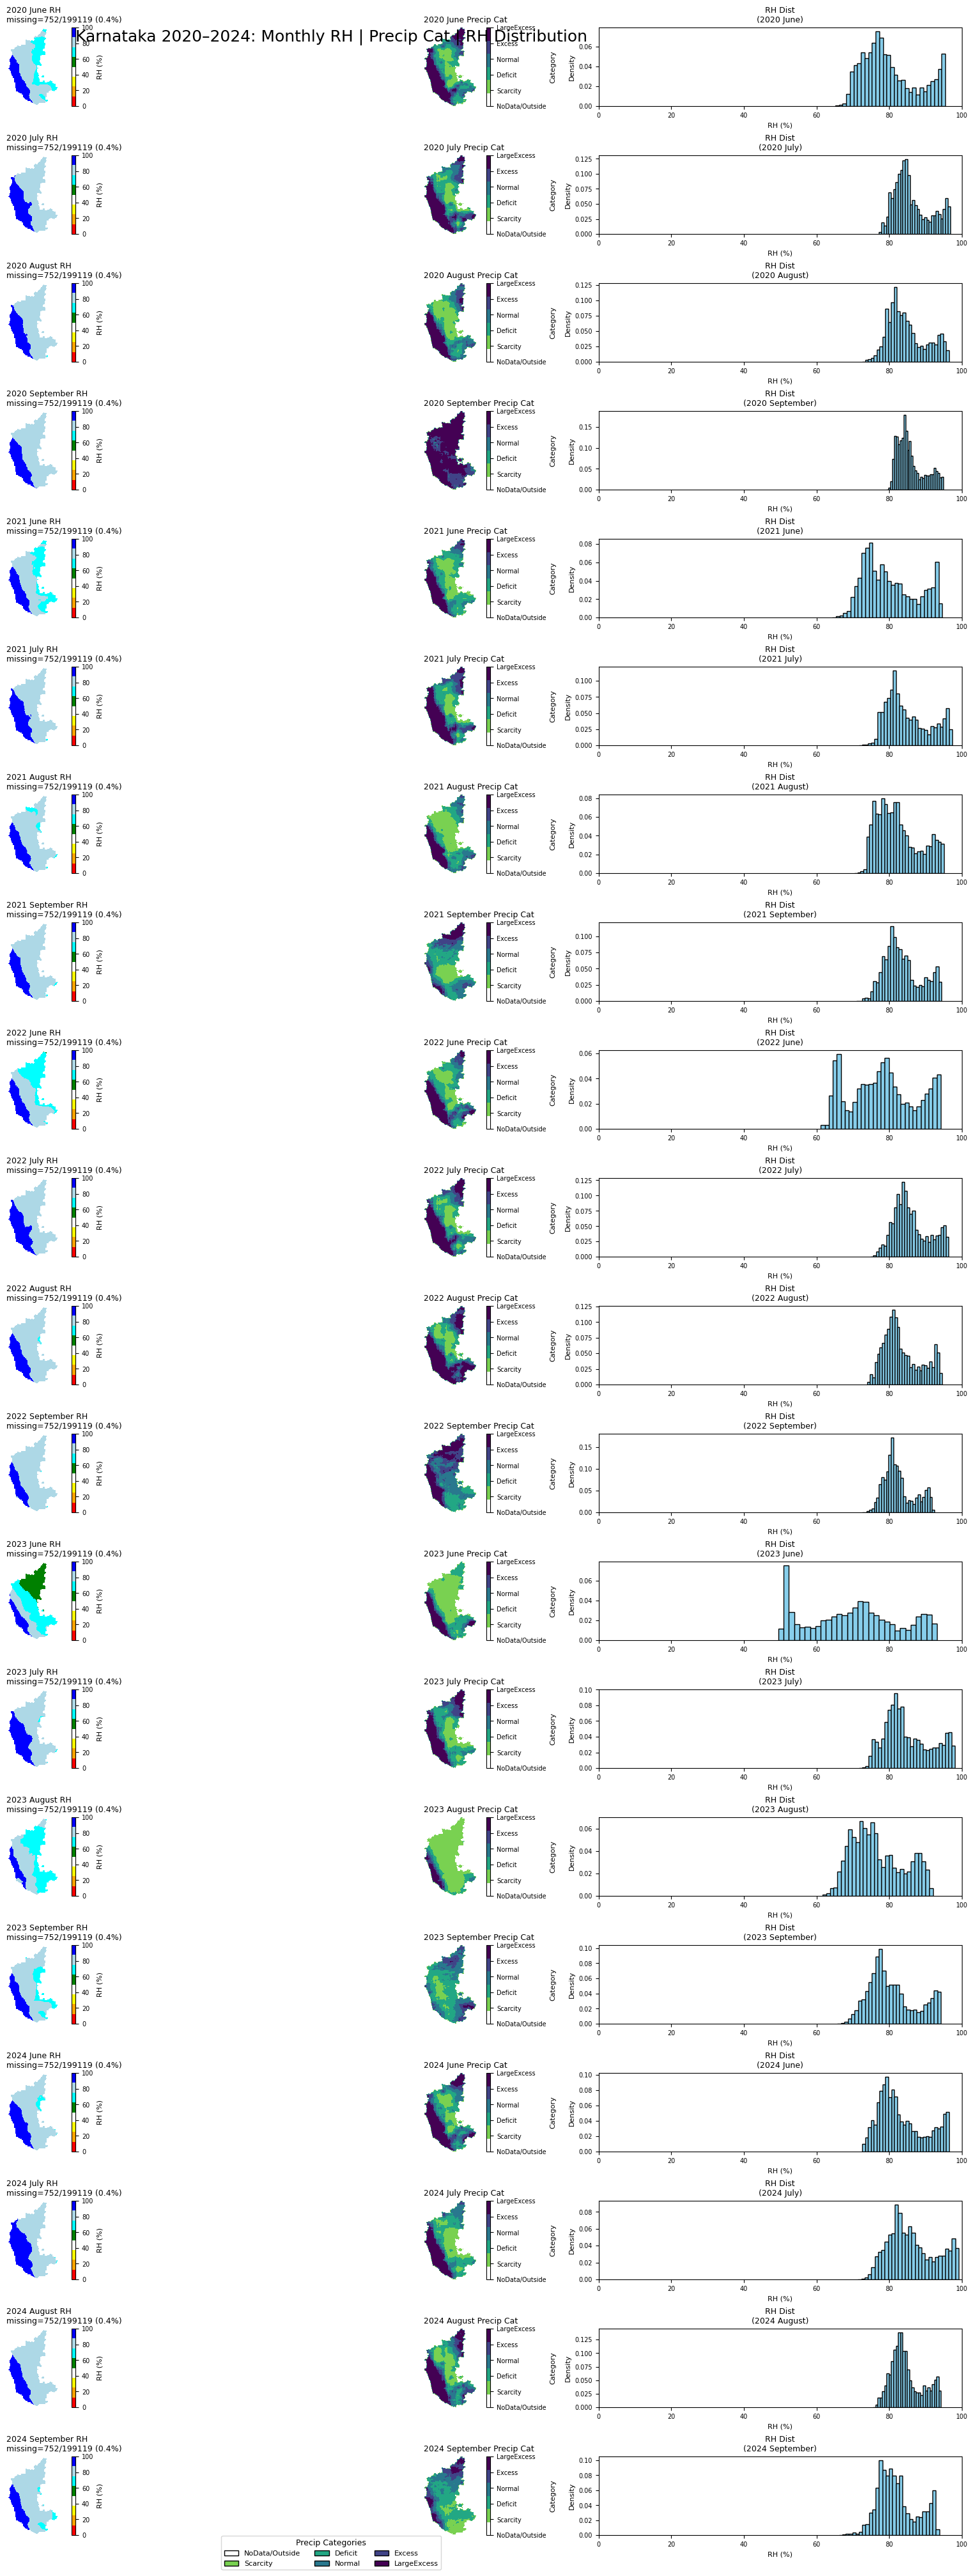

In [16]:
import os
import rasterio
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from rasterio.features import geometry_mask

# ------------------------------------------------------------------------------
# 1) FILE PATHS (for Karnataka)
# ------------------------------------------------------------------------------
rh_tiff_path        = "Karnataka_X_Relative_Humidity.tif"    # 20 bands (Jun–Sep 2020–2024)
precip_raw_tiff     = "Karnataka_Y_Precipitation_CHIRPS.tif" # 25 bands (2020–2024 × 5)
precip_cat_tiff     = "Karnataka_Y_Precipitation_GT_geotif.tif"  # 25 bands (2020–2024 × 5)
india_shp           = "SateMask/gadm41_IND_1.shp"             # India admin-1 boundaries

for f in (rh_tiff_path, precip_raw_tiff, precip_cat_tiff, india_shp):
    if not os.path.isfile(f):
        raise FileNotFoundError(f"Cannot find {f!r} in {os.getcwd()}")

# ------------------------------------------------------------------------------
# 2) LOAD & MASK RELATIVE HUMIDITY
# ------------------------------------------------------------------------------
with rasterio.open(rh_tiff_path) as src:
    rh_bands     = src.read().astype(np.float32)  # shape=(20,H,W)
    rh_tr, rh_crs = src.transform, src.crs
    H, W         = src.height, src.width
    bounds       = src.bounds

if rh_bands.shape[0] != 20:
    raise ValueError(f"Expected 20 bands in {rh_tiff_path}")

# load Karnataka polygon, reproject if needed
gdf = gpd.read_file(india_shp)
gdf_kar = gdf[gdf["NAME_1"].str.lower()=="karnataka"].copy()
if gdf_kar.empty:
    raise ValueError("No 'Karnataka' feature found in shapefile")
if gdf_kar.crs != rh_crs:
    gdf_kar = gdf_kar.to_crs(rh_crs)

kar_geom = [gdf_kar.geometry.union_all()]
kar_mask = geometry_mask(
    kar_geom, transform=rh_tr, invert=True, out_shape=(H, W)
)
total_pixels = kar_mask.sum()
print(f"Total pixels inside Karnataka boundary: {total_pixels}\n")

# mask RH outside Karnataka
for i in range(20):
    arr = rh_bands[i]
    arr[~kar_mask] = np.nan
    rh_bands[i] = arr

# ------------------------------------------------------------------------------
# 3) LOAD & MASK RAW PRECIPITATION
# ------------------------------------------------------------------------------
with rasterio.open(precip_raw_tiff) as src:
    pr_raw_full, pr_tr, pr_crs = src.read().astype(np.float32), src.transform, src.crs
    H_pr, W_pr                = src.height, src.width

if pr_raw_full.shape[0] != 25:
    raise ValueError(f"Expected 25 bands in {precip_raw_tiff}")

# mask raw precip outside Karnataka
gdf_kar_pr = gdf_kar.to_crs(pr_crs)
kar_mask_pr = geometry_mask(
    [gdf_kar_pr.geometry.union_all()],
    transform=pr_tr, invert=True, out_shape=(H_pr, W_pr)
)
for i in range(25):
    a = pr_raw_full[i]
    a[~kar_mask_pr] = np.nan
    pr_raw_full[i] = a

# ------------------------------------------------------------------------------
# 4) LOAD & MASK PRECIPITATION CATEGORY
# ------------------------------------------------------------------------------
with rasterio.open(precip_cat_tiff) as src:
    pr_cat_full = src.read().astype(np.int8)

if pr_cat_full.shape[0] != 25:
    raise ValueError(f"Expected 25 bands in {precip_cat_tiff}")

# mask precip-cat outside Karnataka → set to -1
for i in range(25):
    c = pr_cat_full[i]
    c[~kar_mask_pr] = -1
    pr_cat_full[i] = c

# ------------------------------------------------------------------------------
# 5) DROP “TOTAL” EVERY 5th BAND → GET 20 MONSOON MONTHS
# ------------------------------------------------------------------------------
monthly_idx = [year*5 + m for year in range(5) for m in range(4)]
rh_mon    = rh_bands
pr_raw_mon = pr_raw_full[monthly_idx]
pr_cat_mon = pr_cat_full[monthly_idx]

# ------------------------------------------------------------------------------
# 6) SETUP YEARS, MONTHS, COLORMAPS
# ------------------------------------------------------------------------------
years = [2020,2021,2022,2023,2024]
months = ["June","July","August","September"]
N = 20

cmap_rh = ListedColormap(["red","orange","yellow","white","green","cyan","lightblue","blue"])
vmin_rh, vmax_rh = 0, 100

cat_colors = ["#ffffff","#79d151","#22a784","#29788e","#404387","#440154"]
cmap_cat   = ListedColormap(cat_colors)
cat_labels = {
    0:"NoData/Outside",1:"Scarcity",2:"Deficit",
    3:"Normal",4:"Excess",5:"LargeExcess"
}
cat_handles = [Patch(facecolor=cat_colors[i], edgecolor="black", label=cat_labels[i])
               for i in range(6)]

# ------------------------------------------------------------------------------
# 7) PRINT MISSING-DATA STATS
# ------------------------------------------------------------------------------
for i in range(N):
    y, m = divmod(i,4)
    yr, mo = years[y], months[m]

    miss_rh  = np.isnan(rh_mon[i][kar_mask]).sum()
    pct_rh   = miss_rh/total_pixels*100

    miss_pr  = np.isnan(pr_raw_mon[i][kar_mask_pr]).sum()
    pct_pr   = miss_pr/total_pixels*100

    print(f"{yr} {mo} → RH missing: {miss_rh}/{total_pixels} ({pct_rh:.2f}%)  |"
          f"  Precip missing: {miss_pr}/{total_pixels} ({pct_pr:.2f}%)")
print()

# ------------------------------------------------------------------------------
# 8) PLOT THE 20×3 PANEL
# ------------------------------------------------------------------------------
fig, axes = plt.subplots(N, 3, figsize=(20, N*2.0), constrained_layout=True)
fig.suptitle("Karnataka 2020–2024: Monthly RH | Precip Cat | RH Distribution",
             fontsize=18, y=0.99)
if N==1:
    axes = axes[np.newaxis,:]

for i in range(N):
    y, m = divmod(i,4)
    yr, mo = years[y], months[m]

    # — RH map —
    arr_rh = rh_mon[i]
    ax0 = axes[i,0]
    im0 = ax0.imshow(arr_rh, cmap=cmap_rh, vmin=vmin_rh, vmax=vmax_rh,
                     extent=[bounds.left,bounds.right,bounds.bottom,bounds.top],
                     origin="upper")
    ax0.set_title(f"{yr} {mo} RH\nmissing="
                  f"{np.isnan(arr_rh[kar_mask]).sum()}/{total_pixels}"
                  f" ({np.isnan(arr_rh[kar_mask]).sum()/total_pixels*100:.1f}%)",
                  loc="left", fontsize=9)
    ax0.axis("off")
    cb0 = fig.colorbar(im0, ax=ax0, fraction=0.04, pad=0.02)
    cb0.set_label("RH (%)", fontsize=8); cb0.ax.tick_params(labelsize=7)

    # — Precip-category map —
    rawc = pr_cat_mon[i]
    disp = np.zeros_like(rawc, dtype=np.int8)
    ok   = (rawc!=-1)
    disp[ok] = rawc[ok]+1
    ax1 = axes[i,1]
    im1 = ax1.imshow(disp, cmap=cmap_cat, vmin=0, vmax=5)
    ax1.set_title(f"{yr} {mo} Precip Cat", loc="left", fontsize=9)
    ax1.axis("off")
    cb1 = fig.colorbar(im1, ax=ax1, fraction=0.04, pad=0.02)
    cb1.set_ticks([0,1,2,3,4,5])
    cb1.set_ticklabels([cat_labels[j] for j in range(6)], fontsize=6)
    cb1.ax.tick_params(labelsize=7); cb1.set_label("Category",fontsize=8)

    # — RH distribution histogram —
    vals = arr_rh[~np.isnan(arr_rh)]
    ax2 = axes[i,2]
    if vals.size:
        ax2.hist(vals.flatten(), bins=30, density=True, edgecolor="black", color="skyblue")
        ax2.set_xlim(vmin_rh, vmax_rh)
    else:
        ax2.text(0.5,0.5,"No Data",ha="center",va="center",color="gray",fontsize=8)
    ax2.set_title(f"RH Dist\n({yr} {mo})", fontsize=9)
    ax2.set_xlabel("RH (%)", fontsize=8); ax2.set_ylabel("Density", fontsize=8)
    ax2.tick_params(labelsize=7)

# bottom legend
fig.legend(handles=cat_handles, loc="lower center", ncol=3,
           frameon=True, title="Precip Categories",
           fontsize=8, title_fontsize=9, bbox_to_anchor=(0.5,-0.005))

plt.show()


In [ ]:
##Karnataka_X_Wind_Speed

In [ ]:
##Karnataka_X_LULC

In [ ]:
##Karnataka_X_Soil_Moisture

In [ ]:
##Karnatka_X_elevation